# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as NeuralNetworkFunctional
from torchvision import datasets, transforms, models
from collections import OrderedDict
import time
import workspace_utils as w_utils
from PIL import Image
import numpy as np

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms
validation_and_test_transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])])

training_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# Load training data
training_dataset = datasets.ImageFolder(train_dir, transform=training_transform)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
# Load validation data
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_and_test_transform)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)
# Load testing data
testing_dataset = datasets.ImageFolder(test_dir, transform=validation_and_test_transform)
testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=32, shuffle=False)

print(f"Loaded:\n- {len(training_dataset)} training datapoints \n- {len(validation_dataset)} validation datapoints \n- {len(testing_dataset)} testing datapoints")

Loaded:
- 6552 training datapoints 
- 818 validation datapoints 
- 819 testing datapoints


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [2]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
n_categories = len(cat_to_name)
print(f"There are {n_categories} keys in the dictionary, therefore {n_categories} possible flower categories")
print(f"Category-to-name dict:{cat_to_name}")

There are 102 keys in the dictionary, therefore 102 possible flower categories
Category-to-name dict:{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trum

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Step 1. Load a Pre-Trained Network
Load a pre-trained network to be used as a robust feature detector.

In [5]:
model = models.resnet50(pretrained=True)
# Freeze model parameters so that we don't backpropagate through them
for param in model.parameters():
    param.requires_grad = False
    
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 47262813.07it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### Step 1.A Replace Classifier
Use our own feed-forward classifier, which is configured to output the same number of possible flower categories.

In [6]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(1024, 512)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.2)),
                          ('fc_last', nn.Linear(512, n_categories)),
                          ('output', nn.LogSoftmax(dim=1))]))

# Assign our classifier to the pre-trained model
model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Step 2. Train the Classifier Layers
Train the classifier layers by using backpropagation and using the pre-trained network to get the features. First, we define a few functions to clean up the implementation:
#### Validate Function

In [7]:
def validate(model, criterion, validation_dataloader, device):
    ''' Runs through validation data and calculates and returns loss and accuracy
        
        Arguments
        ---------
        model: model to validate
        criterion: used to calculate model validation loss
        validation_dataloader: dataloader for validation data
        device: 'cpu' or 'gpu'
        
        Returns
        -------
        accuracy: calculated accuracy for all validation data
        validation_loss: calculated loss for all validation data
    '''
    # Put model in 'evaluation' mode
    model.eval()
    
    with torch.no_grad():
        validation_loss = 0
        accuracy = 0
        for inputs, labels in validation_dataloader:
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            validation_logps = model.forward(inputs)
            # Calculate loss
            loss = criterion(validation_logps, labels)
            validation_loss += loss.item()
            # Calculate accuracy
            validation_ps = torch.exp(validation_logps)
            top_p, top_class = validation_ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    # Put model back in 'training' mode
    model.train()
    
    return accuracy, validation_loss 

#### Train Function

In [8]:
def train(model, device, epochs, optimizer, criterion, training_dataloader, validation_dataloader, print_every=0):
    ''' Trains the provided model with the following arguments:
        
        Arguments
        ---------
        model: model to be used to train
        device: 'cpu' or 'gpu'
        epochs: number of training iterations over the entire learning dataset
        optimizer: optimizer to be used to update weights after backpropagation (already configured with a learn rate)
        criterion: used to calculate model loss and execute backpropagation
        training_dataloader: dataloader for training data
        validation_dataloader: dataloader for validation data
        print_every: will print intermediate step stats if provided value > 0. Defaults to zero (no intermediate printing)
        
        Returns
        -------
        train_losses: list of all training loss values that can be used in plots
        validation_losses: list of all validation loss values that can be used in plots
    '''
    print(f"\n****TRAINING (printing model stats every {print_every} steps)****\n Device: {device}, Epochs: {epochs}, Training Dataset Length: {len(training_dataloader)},  Validation Dataset Length: {len(validation_dataloader)}")
    
    model.to(device)
    model.train()
    step = 0
    training_loss = 0
    train_losses, validation_losses = [], []
    
    for epoch in range(epochs):
        
        for inputs, labels in training_dataloader:
            step += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            # Reset the gradients for every pass
            optimizer.zero_grad()

            # 1. Forward pass
            logps = model.forward(inputs)
            # 2. Calculate loss
            loss = criterion(logps, labels)
            # 3. Backpropagate
            loss.backward()
            # 4. Update weights
            optimizer.step()

            training_loss += loss.item()
            
            # Run Validations    
            if print_every > 0 and step % print_every == 0:
                validation_loss = 0
                accuracy = 0

                # Validate
                calculated_accuracy, calculated_validation_loss = validate(model, criterion, validation_dataloader, device)
                validation_loss += calculated_validation_loss
                accuracy += calculated_accuracy
                
                # Update loss lists
                train_losses.append(training_loss/print_every)
                validation_losses.append(validation_loss/len(validation_dataloader))

                print("Step {} - Epoch: {}/{} | ".format(step, epoch + 1, epochs),
                      "Training Loss: {:.3f} | ".format(training_loss/print_every),
                      "Validation Loss: {:.3f} | ".format(validation_loss/len(validation_dataloader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validation_dataloader)))
                training_loss = 0
                
    return train_losses, validation_losses

#### Execute Training Process

In [9]:
# Fetch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-params
epochs = 8
learn_rate = 0.0003

# Create an optimizer to update the weights
print(f"Configured learning rate:{learn_rate}, Chosen model:ResNet50, Optimizer:Adam")
optimizer = optim.Adam(model.fc.parameters(), lr=learn_rate)
criterion = nn.NLLLoss()
print_every = 100

start = time.time()

with w_utils.active_session():
    train_losses, validation_losses = train(model, device, epochs, optimizer, criterion, training_dataloader, validation_dataloader, print_every)
        
print(f"Total run time: {time.time()-start}")

Configured learning rate:0.0003, Chosen model:ResNet50, Optimizer:Adam

****TRAINING (printing model stats every 100 steps)****
 Device: cuda, Epochs: 8, Training Dataset Length: 205,  Validation Dataset Length: 26
Step 100 - Epoch: 1/8 |  Training Loss: 4.380 |  Validation Loss: 3.823 |  Validation Accuracy: 0.207
Step 200 - Epoch: 1/8 |  Training Loss: 3.433 |  Validation Loss: 2.390 |  Validation Accuracy: 0.418
Step 300 - Epoch: 2/8 |  Training Loss: 2.422 |  Validation Loss: 1.608 |  Validation Accuracy: 0.593
Step 400 - Epoch: 2/8 |  Training Loss: 1.904 |  Validation Loss: 1.176 |  Validation Accuracy: 0.673
Step 500 - Epoch: 3/8 |  Training Loss: 1.564 |  Validation Loss: 0.939 |  Validation Accuracy: 0.754
Step 600 - Epoch: 3/8 |  Training Loss: 1.404 |  Validation Loss: 0.875 |  Validation Accuracy: 0.753
Step 700 - Epoch: 4/8 |  Training Loss: 1.256 |  Validation Loss: 0.746 |  Validation Accuracy: 0.808
Step 800 - Epoch: 4/8 |  Training Loss: 1.182 |  Validation Loss: 0.601

#### Training Loss VS Validation Loss

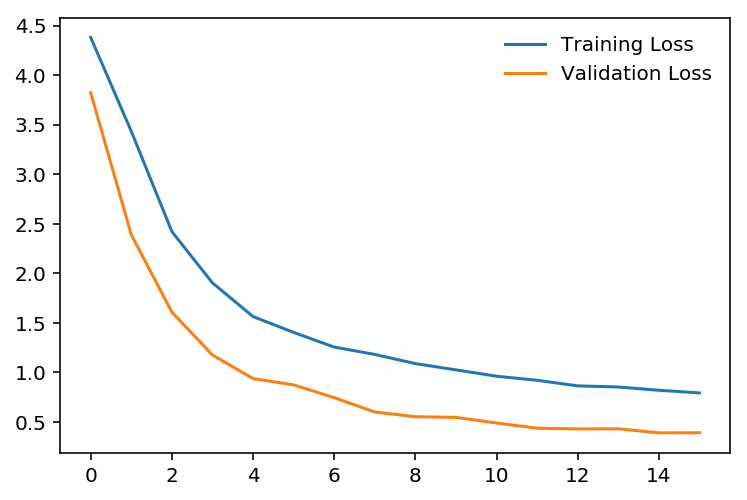

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend(frameon=False);

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

#### Testing Function

In [11]:
def test(model, criterion, testing_dataloader, device):
    ''' Iterates through test dataset to verify the accuracy of the trained model
        
        Arguments
        ---------
        model: used for predictions on the test dataset
        criterion: used to calculate loss
        testing_dataloader: data loader containing testing dataset
        device: 'cpu' or 'gpu'
    '''
    
    model.to(device)
    model.eval()
    print(f"Testing model (dataset length: {len(testing_dataloader)}) on device: {device}")
    
    with torch.no_grad():
        
        test_loss = 0
        test_accuracy = 0
        
        for images, labels in testing_dataloader:
            # Move images and labels to selected device
            images, labels = images.to(device), labels.to(device)
            
            test_logps = model(images)
            test_loss += criterion(test_logps, labels)
            
            # Calculate Accuracy
            test_ps = torch.exp(test_logps)
            top_p, top_class = test_ps.topk(1, dim=1)
            test_equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(test_equals.type(torch.FloatTensor))
            
        print("Test Loss: {:.3f}".format(test_loss/len(testing_dataloader)),
              " | Test Accuracy: {:.3f}".format(test_accuracy/len(testing_dataloader)))

#### Execute Testing Process

In [12]:
with w_utils.active_session():
    test_start = time.time()
    test(model, criterion, testing_dataloader, device)
    print(f"Testing time: {time.time() - test_start}")    

Testing model (dataset length: 26) on device: cuda
Test Loss: 0.443  | Test Accuracy: 0.875
Testing time: 15.462806940078735


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
checkpoint = {'state_dict': model.state_dict(),
              'class_to_index': training_dataset.class_to_idx,
              'optimizer_state_dict': optimizer.state_dict(),
              'epochs': epochs,
              'inputs': 2048,
              'outputs': n_categories,
              'hidden_layers': [1024, 512],
              'dropout': 0.2,
              'architecture': 'resnet50'}

torch.save(checkpoint, 'checkpoint-2.pth')

State dictionary keys:
 odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.conv3.weight', 'layer1.1.bn3.weight', 'layer1.1.bn3.bias', 'layer1.1.bn3.r

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

#### Helper Functions to Build a Model

In [3]:
def freeze_pretrained_model_params(pretrained_model):
    for param in pretrained_model.parameters():
        param.requires_grad = False
    return pretrained_model

def build_feedforward_classifier(input_units, hidden_layer_inputs, output_units, dropout):
    ''' Builds a feed-forward classifier based on the provided arguments. The output uses 'LogSoftmax'
        
        Arguments
        ---------
        input_units: number of input units received by this classifier
        hidden_layer_inputs: list containing input units for each hidden layer to be added
        output_units: number of output units for this classifier
        dropout: dropout value to be used for each applicable layer
        
        Returns
        -------
        A feed-forward classifier
    '''
    
    all_layer_inputs = [input_units] + hidden_layer_inputs
    
    classifier_elements = OrderedDict()
    
    # Build all layers, activation functions, and dropout
    for i, input_output_pair in enumerate(zip(all_layer_inputs, all_layer_inputs[1:])):
        classifier_elements['fc' + str(i + 1)] = nn.Linear(input_output_pair[0], input_output_pair[1])
        classifier_elements['relu' + str(i + 1)] = nn.ReLU()
        classifier_elements['dropout' + str(i + 1)] = nn.Dropout(dropout)
        
    # Build last layer
    classifier_elements['fc_last'] = nn.Linear(all_layer_inputs[-1], output_units)
    classifier_elements['output'] = nn.LogSoftmax(dim=1)
    
    classifier = nn.Sequential(classifier_elements)
    return classifier
    

def build_model(architecture, classifier_hidden_units_list, classifier_outputs, dropout):
    ''' Loads a pre-trained model based on the provided architecture, and replaces the model classifier with a
        feed-forward classifier based on the provided hidden layers input units and number of outputs
        
        Arguments
        ---------
        architecture: pre-trained model architecture to use. Valid values are 'alexnet', 'vgg19-bn', and 'resnet50' 
        classifier_hidden_units_list: list of hidden layer inputs to use. e.g. [100, 50, 25] would use 3 hidden layers
                                      with 100, 50, and 25 input units each
        classifier_outputs: number of outputs for this model's feed forward classifier
        dropout: dropout value to be used to all layers except the last one
        
        Returns
        -------
        A pre-trained model (frozen params) with a feed-forward classifier defined by the provided arguments
    '''
    supported_architectures = ['alexnet', 'vgg19-bn', 'resnet50']
    if architecture.lower() not in supported_architectures:
        raise Exception(f"Provided architecture '{architecture}' is not supported. Supported architectures: {supported_architectures}")
    
    model = None
    
    if architecture.lower() == 'alexnet':
        model = models.alexnet(pretrained=True)
        freeze_pretrained_model_params(model)
        inputs = model.classifier[0].in_features
        model.classifier = build_feedforward_classifier(inputs, classifier_hidden_units_list, classifier_outputs, dropout)
    elif architecture.lower() == 'vgg19-bn':
        model = models.vgg19_bn(pretrained=True)
        freeze_pretrained_model_params(model)
        inputs = model.classifier[1].in_features
        model.classifier = build_feedforward_classifier(inputs, classifier_hidden_units_list, classifier_outputs, dropout)
    elif architecture.lower() == 'resnet50':
        model = models.resnet50(pretrained=True)
        freeze_pretrained_model_params(model)
        inputs = model.fc.in_features
        model.fc = build_feedforward_classifier(inputs, classifier_hidden_units_list, classifier_outputs, dropout)

    return model

#### Load Checkpoint Function

In [4]:
def load_checkpoint(file_path, device):
    ''' Loads a checkpoint onto a new model based on the checkpoint's configuration
        
        Arguments
        ---------
        file_path: path containing the checkpoint file
        device: string that determines where to load the model/checkpoint: 'cuda' vs 'cpu'
        
        Returns
        -------
        model: A pre-trained model with a state derived from the provided checkpoint
        checkpoint: The checkpoint used to load the model in case the caller needs additional stored information
    '''
    
    valid_devices = ['cpu', 'cuda']
    device = device.lower()
    if device not in valid_devices:
        raise Exception(f"Invalid device '{device}'! Valid options are: {valid_devices}")
    
    checkpoint = None
    pretrained_model = None
    
    if device == 'cpu':
        checkpoint = torch.load(file_path, map_location=device)
        pretrained_model = build_model(checkpoint['architecture'],
                                       checkpoint['hidden_layers'],
                                       checkpoint['outputs'],
                                       checkpoint['dropout'])
        pretrained_model.load_state_dict(checkpoint['state_dict'])        
    else:
        checkpoint = torch.load(file_path)
        pretrained_model = build_model(checkpoint['architecture'],
                                       checkpoint['hidden_layers'],
                                       checkpoint['outputs'],
                                       checkpoint['dropout'])
        pretrained_model.load_state_dict(checkpoint['state_dict'])
        pretrained_model = pretrained_model.to(torch.device(device))
        
    
    return pretrained_model, checkpoint

Load checkpoint onto a new model with the same architecture as the checkpoint architecture:

In [5]:
reloaded_model = load_checkpoint('checkpoint-2.pth', 'cpu')
reloaded_model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 104934251.40it/s]


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1, 1), strid

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [6]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # 1. Scale shortest side to 256 pixels, keep aspect ratio
    scaled_image = None
    width_idx = 0
    height_idx = 1
    smallest_dim = min(image.size[width_idx], image.size[height_idx])
    smallest_dim_idx = image.size.index(smallest_dim)
    
    if smallest_dim_idx == width_idx:
        resize_scalar = 256/image.width
        scaled_image = image.resize((256, int(image.height * resize_scalar)))
    else:
        resize_scalar = 256/image.height
        scaled_image = image.resize((int(image.width * resize_scalar), 256))
        
    # 2. Crop the image (center 224 X 224)
    cropped_image = scaled_image.crop(box=(scaled_image.width/2-112,
                                           scaled_image.height/2-112,
                                           scaled_image.width/2+112,
                                           scaled_image.height/2+112))
        
    # 3. Normalize color channels
    means = np.array([0.485, 0.456, 0.406])
    standard_deviations = np.array([0.229, 0.224, 0.225])
    
    image_array = np.array(cropped_image)/255.0
    normalized_image_array = (image_array - means) / standard_deviations
    
    # 4. Transpose to match Pytorch's img format (color channel in the first dimension)
    transposed_image_array = normalized_image_array.transpose((2,0,1))
    
    return transposed_image_array

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [7]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [8]:
test_flower_path = "flowers/test/1/image_06743.jpg"
flower_pic = Image.open(test_flower_path)
flower_pic.size

(500, 601)

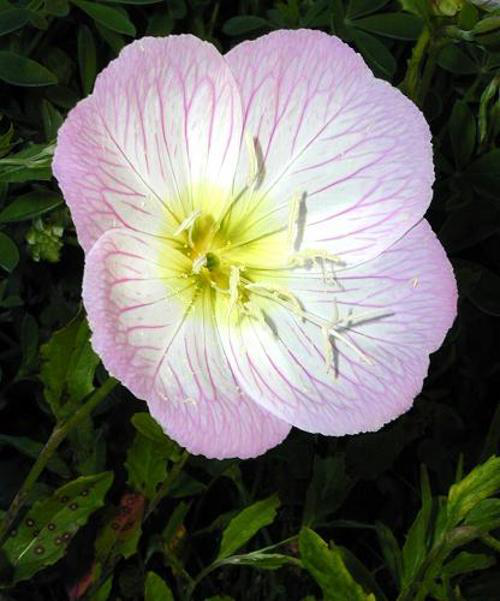

In [9]:
flower_pic

Processed shape: (3, 224, 224)


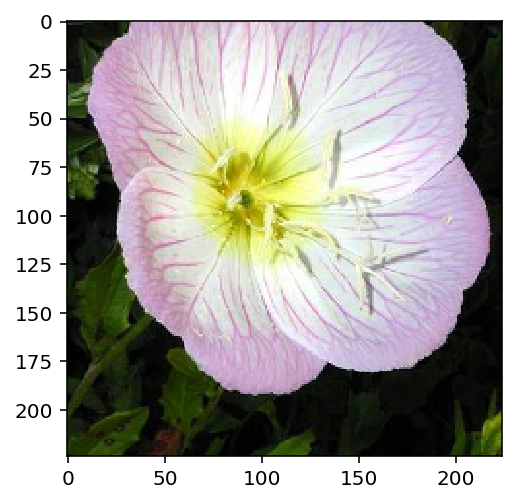

In [10]:
processed = process_image(flower_pic)
print(f"Processed shape: {processed.shape}")
imshow(torch.from_numpy(processed))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [11]:
def predict(image_path, model, device, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        
        Arguments
        ---------
        image_path: path to the image to load and run through our model prediction
        model: pre-trained model to use for flower category prediction
        topk: number of top identified classes to return
        
        Returns
        -------
        top_probabilities: top K probabilities predicted by the model
        top_classes: top K classes predicted by the model
    '''
    
    image = Image.open(image_path)
    processed_img = torch.from_numpy(process_image(image)).float()
    processed_img = torch.unsqueeze(processed_img, 0)
    processed_img = processed_img.to(torch.device(device))
    
    model.eval()
    
    with torch.no_grad():
        logps = model(processed_img)
        ps = torch.exp(logps)
        top_probabilities, top_classes = ps.topk(topk, dim=1)
    
    return top_probabilities, top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [13]:
k = 5
top_probabilities, top_classes = predict(test_flower_path, reloaded_model[0], 'cpu', k)
print(f"Top probabilities:\n{top_probabilities}\n",
      f"Top classes:\n{top_classes}\n")

classes_to_indexes = reloaded_model[1]['class_to_index']
indexes_to_classes = {v: k for k, v in classes_to_indexes.items()}

named_classes = [cat_to_name[indexes_to_classes[top_class]] for top_class in top_classes.squeeze().cpu().numpy()]

Top probabilities:
tensor([[ 0.6464,  0.1721,  0.0543,  0.0430,  0.0339]])
 Top classes:
tensor([[  0,  77,  87,  49,  76]])



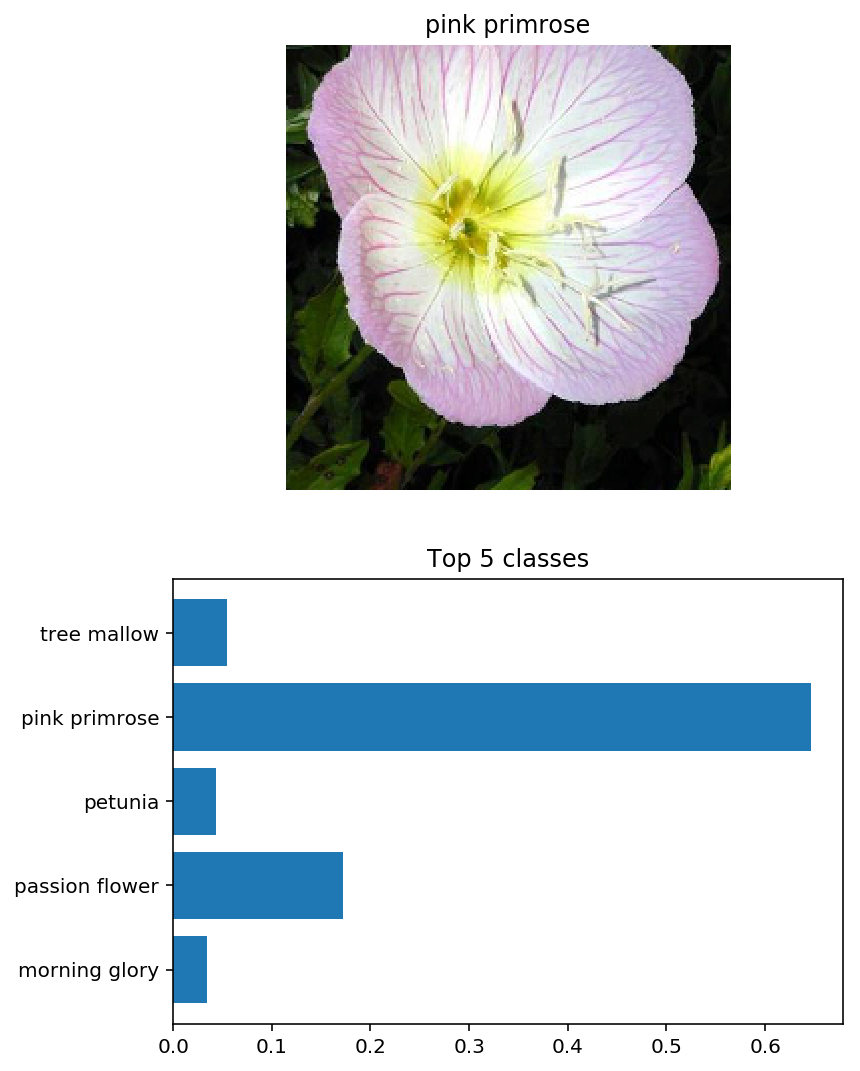

In [14]:
fig, axes = plt.subplots(figsize=(6,9), nrows=2)
axes[1].barh(named_classes, top_probabilities.squeeze().numpy())
axes[1].set_title(f"Top {k} classes")
axes[0].set_title(named_classes[0])
axes[0].axis('off')
imshow(torch.from_numpy(processed), axes[0]);